In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [2]:
pip install rdkit pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 44.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# RDKit for molecular features
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

# ML models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")
print(f"✓ NumPy: {np.__version__}")
print(f"✓ Pandas: {pd.__version__}")

✓ All imports successful!
✓ NumPy: 2.0.2
✓ Pandas: 2.2.2


In [4]:
import os
print("Available datasets:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Available datasets:
/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [5]:
df_large = pd.read_csv(
    '/kaggle/input/leash-BELKA/train.csv',
    nrows=100000  # Only load first 1M rows
)

print(f"Loaded {len(df_large):,} rows")

# Sample 50K from these
SAMPLE_SIZE = 50000
df = df_large.groupby(['protein_name', 'binds'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 6), random_state=42)
).reset_index(drop=True)

print(f"✓ Final sample: {len(df):,} molecules")

# Free memory
del df_large
import gc
gc.collect()


Loaded 100,000 rows
✓ Final sample: 25,234 molecules


0

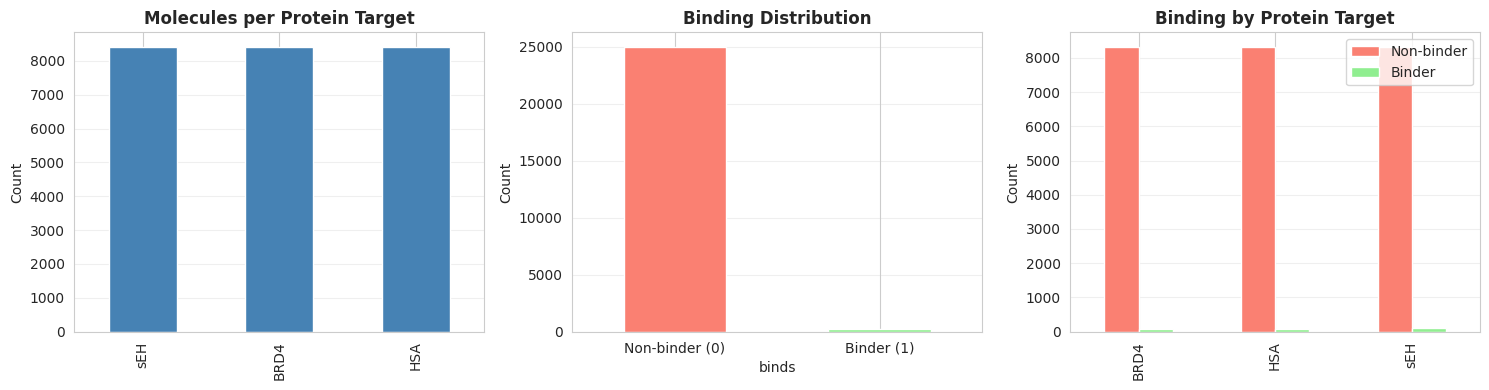


Overall binding rate: 0.93%


In [6]:
# Visualize data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Protein distribution
df['protein_name'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Molecules per Protein Target', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')
axes[0].grid(axis='y', alpha=0.3)

# Binding distribution
df['binds'].value_counts().plot(kind='bar', ax=axes[1], color=['salmon', 'lightgreen'])
axes[1].set_title('Binding Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Non-binder (0)', 'Binder (1)'], rotation=0)
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

# Binding by protein
binding_by_protein = df.groupby('protein_name')['binds'].value_counts().unstack()
binding_by_protein.plot(kind='bar', ax=axes[2], color=['salmon', 'lightgreen'], stacked=False)
axes[2].set_title('Binding by Protein Target', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('')
axes[2].legend(['Non-binder', 'Binder'])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall binding rate: {df['binds'].mean():.2%}")

In [7]:
# Look at example molecules
print("Example molecules:\n")
df[['molecule_smiles', 'protein_name', 'binds']].head(10)

Example molecules:



,molecule_smiles,protein_name,binds
0,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2cc(OC)ns2)nc(...,BRD4,0
1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(=O)NCC=C)nc(N...,BRD4,0
2,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(C)(C)C(=O)N2C...,BRD4,0
3,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(C)OCC=C)nc(NC...,BRD4,0
4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCSC(C)=O)nc(Nc2...,BRD4,0
5,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC(C)S(C)=O)nc(...,BRD4,0
6,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCN2CCC(C)(F)C2)...,BRD4,0
7,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NC[C@H]2C[C@H](c3...,BRD4,0
8,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(=O)N2CCN(C)CC...,BRD4,0
9,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc...,BRD4,0


In [8]:
def smiles_to_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """
    Convert SMILES string to Morgan fingerprint (updated API)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(n_bits)
        
        # NEW API: Use MorganGenerator
        from rdkit.Chem import rdFingerprintGenerator
        
        # Create generator
        morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
        
        # Generate fingerprint
        fp = morgan_gen.GetFingerprint(mol)
        
        return np.array(fp)
    except:
        return np.zeros(n_bits)

In [9]:
# Generate fingerprints for all molecules
print("Generating Morgan fingerprints for all molecules...")
print("This will take 1-2 minutes for 50K molecules...\n")

fingerprints = []
for i, smiles in enumerate(df['molecule_smiles'].values):
    fp = smiles_to_morgan_fingerprint(smiles)
    fingerprints.append(fp)
    
    if (i + 1) % 10000 == 0:
        print(f"  Processed {i+1:,} / {len(df):,} molecules")

X_mol = np.array(fingerprints)
print(f"\n✓ Molecular features shape: {X_mol.shape}")

Generating Morgan fingerprints for all molecules...
This will take 1-2 minutes for 50K molecules...

  Processed 10,000 / 25,234 molecules
  Processed 20,000 / 25,234 molecules

✓ Molecular features shape: (25234, 2048)


In [10]:
# Add protein one-hot encoding
protein_names = df['protein_name'].unique()
protein_to_idx = {name: i for i, name in enumerate(protein_names)}

X_protein = np.zeros((len(df), len(protein_names)))
for i, protein in enumerate(df['protein_name'].values):
    X_protein[i, protein_to_idx[protein]] = 1

# Combine molecular + protein features
X = np.concatenate([X_mol, X_protein], axis=1)
y = df['binds'].values

print(f"\n✓ Final feature matrix: {X.shape}")
print(f"  - Molecular features: {X_mol.shape[1]}")
print(f"  - Protein features: {X_protein.shape[1]}")
print(f"  - Total: {X.shape[1]}")
print(f"\n✓ Target vector: {y.shape}")
print(f"  - Binding rate: {y.mean():.2%}")


✓ Final feature matrix: (25234, 2051)
  - Molecular features: 2048
  - Protein features: 3
  - Total: 2051

✓ Target vector: (25234,)
  - Binding rate: 0.93%


In [11]:
# Cross-validation setup
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"Using {N_SPLITS}-fold stratified cross-validation")
print(f"Training on {len(y)} samples\n")

Using 5-fold stratified cross-validation
Training on 25234 samples



In [12]:

print("="*60)
print("TRAINING XGBOOST")
print("="*60)

xgb_models = []
xgb_oof_preds = np.zeros(len(y))
xgb_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train XGBoost - FIXED VERSION
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        max_depth=8,
        learning_rate=0.05,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        early_stopping_rounds=30  # ← Move it here (inside the model constructor)
    )
    
    # Fit WITHOUT early_stopping_rounds parameter
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predict
    y_pred = model.predict_proba(X_val)[:, 1]
    xgb_oof_preds[val_idx] = y_pred
    
    # Metrics
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    
    print(f"  Validation AUC: {auc:.4f}")
    print(f"  Validation AP:  {ap:.4f}")
    
    xgb_models.append(model)
    xgb_scores.append({'fold': fold + 1, 'auc': auc, 'ap': ap})

# Overall performance
xgb_auc = roc_auc_score(y, xgb_oof_preds)
xgb_ap = average_precision_score(y, xgb_oof_preds)

print(f"\n{'='*60}")
print(f"XGBoost Overall Performance:")
print(f"  AUC: {xgb_auc:.4f}")
print(f"  AP:  {xgb_ap:.4f}")
print(f"{'='*60}")

TRAINING XGBOOST

Fold 1/5
  Validation AUC: 0.9426
  Validation AP:  0.3476

Fold 2/5
  Validation AUC: 0.8700
  Validation AP:  0.3461

Fold 3/5
  Validation AUC: 0.9223
  Validation AP:  0.4403

Fold 4/5
  Validation AUC: 0.8571
  Validation AP:  0.2169

Fold 5/5
  Validation AUC: 0.9386
  Validation AP:  0.4033

XGBoost Overall Performance:
  AUC: 0.9047
  AP:  0.3292


In [13]:
print("="*60)
print("TRAINING LIGHTGBM")
print("="*60)

lgb_models = []
lgb_oof_preds = np.zeros(len(y))
lgb_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train LightGBM
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        num_leaves=64,
        learning_rate=0.05,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    
    # Fit with callbacks
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(30, verbose=False)]
    )
    
    # Predict
    y_pred = model.predict_proba(X_val)[:, 1]
    lgb_oof_preds[val_idx] = y_pred
    
    # Metrics
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    
    print(f"  Validation AUC: {auc:.4f}")
    print(f"  Validation AP:  {ap:.4f}")
    
    lgb_models.append(model)
    lgb_scores.append({'fold': fold + 1, 'auc': auc, 'ap': ap})

# Overall performance
lgb_auc = roc_auc_score(y, lgb_oof_preds)
lgb_ap = average_precision_score(y, lgb_oof_preds)

print(f"\n{'='*60}")
print(f"LightGBM Overall Performance:")
print(f"  AUC: {lgb_auc:.4f}")
print(f"  AP:  {lgb_ap:.4f}")
print(f"{'='*60}")

TRAINING LIGHTGBM

Fold 1/5
  Validation AUC: 0.9415
  Validation AP:  0.3076

Fold 2/5
  Validation AUC: 0.9274
  Validation AP:  0.3313

Fold 3/5
  Validation AUC: 0.9461
  Validation AP:  0.4493

Fold 4/5
  Validation AUC: 0.9075
  Validation AP:  0.2484

Fold 5/5
  Validation AUC: 0.9495
  Validation AP:  0.4314

LightGBM Overall Performance:
  AUC: 0.9095
  AP:  0.3136


In [14]:
print("="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

rf_models = []
rf_oof_preds = np.zeros(len(y))
rf_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train Random Forest
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict_proba(X_val)[:, 1]
    rf_oof_preds[val_idx] = y_pred
    
    # Metrics
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    
    print(f"  Validation AUC: {auc:.4f}")
    print(f"  Validation AP:  {ap:.4f}")
    
    rf_models.append(model)
    rf_scores.append({'fold': fold + 1, 'auc': auc, 'ap': ap})

# Overall performance
rf_auc = roc_auc_score(y, rf_oof_preds)
rf_ap = average_precision_score(y, rf_oof_preds)

print(f"\n{'='*60}")
print(f"Random Forest Overall Performance:")
print(f"  AUC: {rf_auc:.4f}")
print(f"  AP:  {rf_ap:.4f}")
print(f"{'='*60}")

TRAINING RANDOM FOREST

Fold 1/5
  Validation AUC: 0.9157
  Validation AP:  0.2504

Fold 2/5
  Validation AUC: 0.8897
  Validation AP:  0.2409

Fold 3/5
  Validation AUC: 0.9146
  Validation AP:  0.4220

Fold 4/5
  Validation AUC: 0.8660
  Validation AP:  0.2135

Fold 5/5
  Validation AUC: 0.9161
  Validation AP:  0.3261

Random Forest Overall Performance:
  AUC: 0.9000
  AP:  0.2581


In [15]:
# Ensemble: Simple average
ensemble_preds = (xgb_oof_preds + lgb_oof_preds + rf_oof_preds) / 3

ensemble_auc = roc_auc_score(y, ensemble_preds)
ensemble_ap = average_precision_score(y, ensemble_preds)

print("="*60)
print("ENSEMBLE PERFORMANCE (Average of 3 models)")
print("="*60)
print(f"  AUC: {ensemble_auc:.4f}")
print(f"  AP:  {ensemble_ap:.4f}")
print("="*60)

ENSEMBLE PERFORMANCE (Average of 3 models)
  AUC: 0.9183
  AP:  0.3399



📊 MODEL COMPARISON

        Model      AUC  Average Precision
     Ensemble 0.918345           0.339923
      XGBoost 0.904715           0.329230
     LightGBM 0.909465           0.313625
Random Forest 0.900026           0.258090


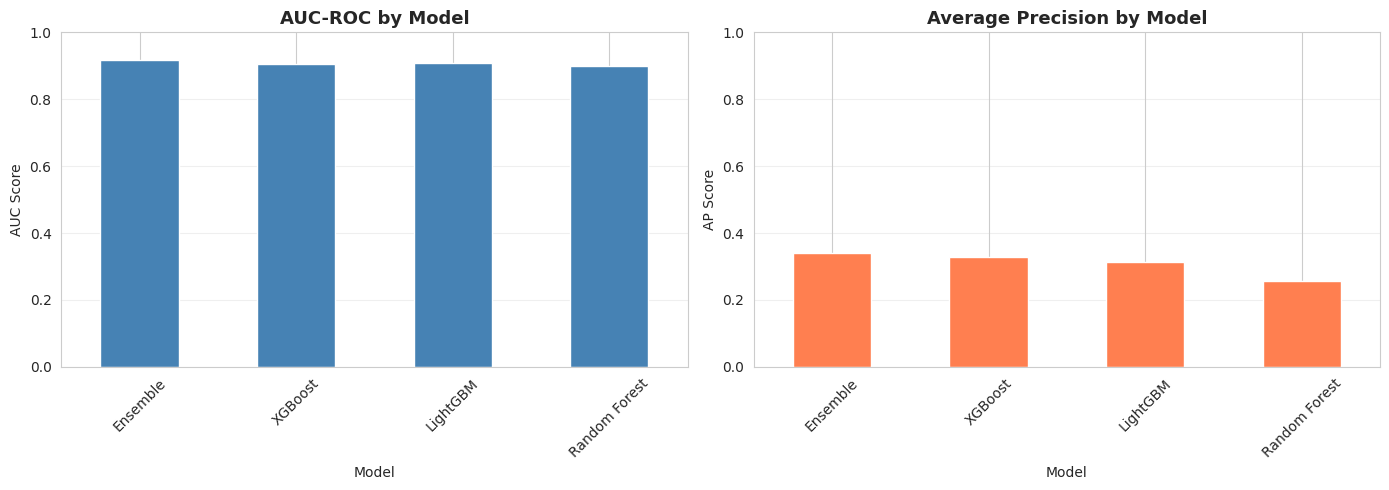

In [16]:
# Summary table
results_df = pd.DataFrame([
    {'Model': 'XGBoost', 'AUC': xgb_auc, 'Average Precision': xgb_ap},
    {'Model': 'LightGBM', 'AUC': lgb_auc, 'Average Precision': lgb_ap},
    {'Model': 'Random Forest', 'AUC': rf_auc, 'Average Precision': rf_ap},
    {'Model': 'Ensemble', 'AUC': ensemble_auc, 'Average Precision': ensemble_ap}
]).sort_values('Average Precision', ascending=False)

print("\n📊 MODEL COMPARISON\n")
print(results_df.to_string(index=False))

# Bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df.plot(x='Model', y='AUC', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('AUC-ROC by Model', fontsize=13, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim([0, 1])
axes[0].set_xticklabels(results_df['Model'], rotation=45)
axes[0].grid(axis='y', alpha=0.3)

results_df.plot(x='Model', y='Average Precision', kind='bar', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Average Precision by Model', fontsize=13, fontweight='bold')
axes[1].set_ylabel('AP Score')
axes[1].set_ylim([0, 1])
axes[1].set_xticklabels(results_df['Model'], rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

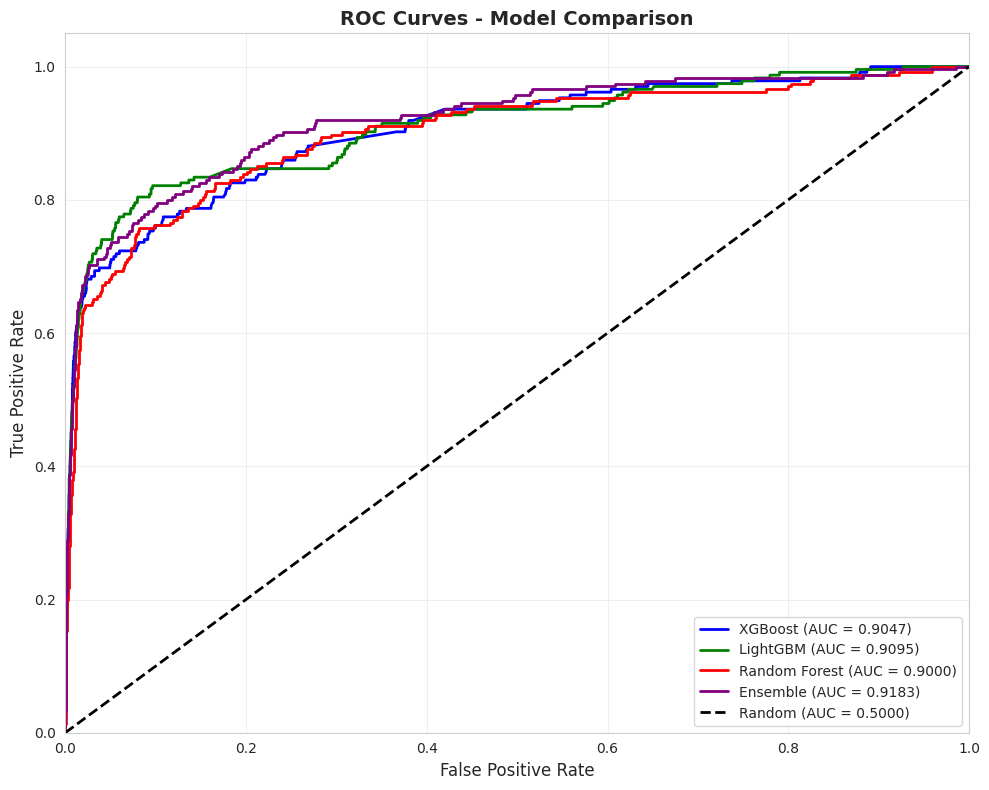

In [17]:
plt.figure(figsize=(10, 8))

# Plot each model
models_data = [
    ('XGBoost', xgb_oof_preds, 'blue'),
    ('LightGBM', lgb_oof_preds, 'green'),
    ('Random Forest', rf_oof_preds, 'red'),
    ('Ensemble', ensemble_preds, 'purple')
]

for model_name, preds, color in models_data:
    fpr, tpr, _ = roc_curve(y, preds)
    auc_score = roc_auc_score(y, preds)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.4f})', color=color)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

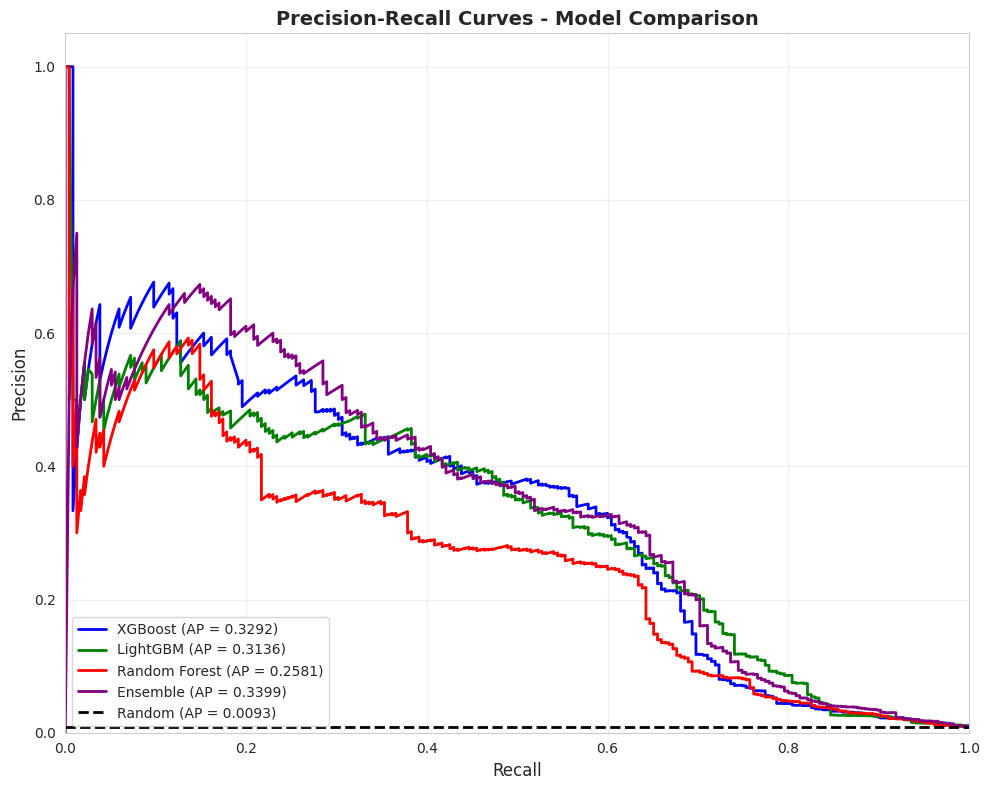

In [18]:
plt.figure(figsize=(10, 8))

for model_name, preds, color in models_data:
    precision, recall, _ = precision_recall_curve(y, preds)
    ap_score = average_precision_score(y, preds)
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {ap_score:.4f})', color=color)

# Random baseline
baseline = y.mean()
plt.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Random (AP = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

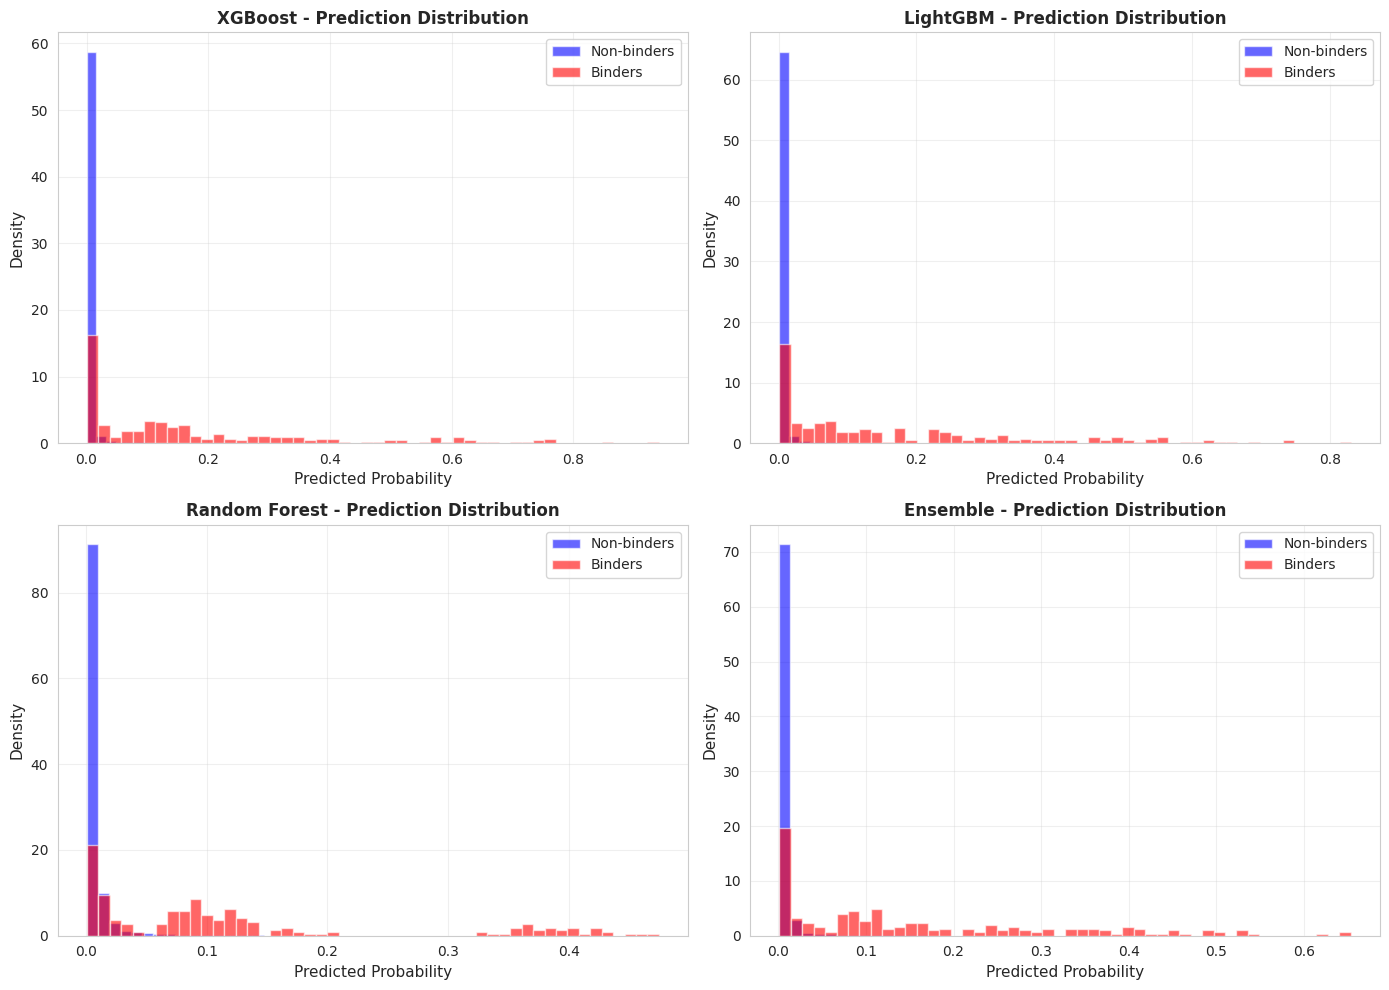

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (model_name, preds, color) in enumerate(models_data):
    ax = axes[idx]
    
    # Histograms for each class
    ax.hist(preds[y == 0], bins=50, alpha=0.6, label='Non-binders', color='blue', density=True)
    ax.hist(preds[y == 1], bins=50, alpha=0.6, label='Binders', color='red', density=True)
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{model_name} - Prediction Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


📊 PERFORMANCE BY PROTEIN TARGET (Ensemble)

Protein      AUC  Average Precision  Samples  Binding Rate
   BRD4 0.951407           0.283410     8415      0.009745
    HSA 0.782073           0.209099     8396      0.007504
    sEH 0.972298           0.488728     8423      0.010685


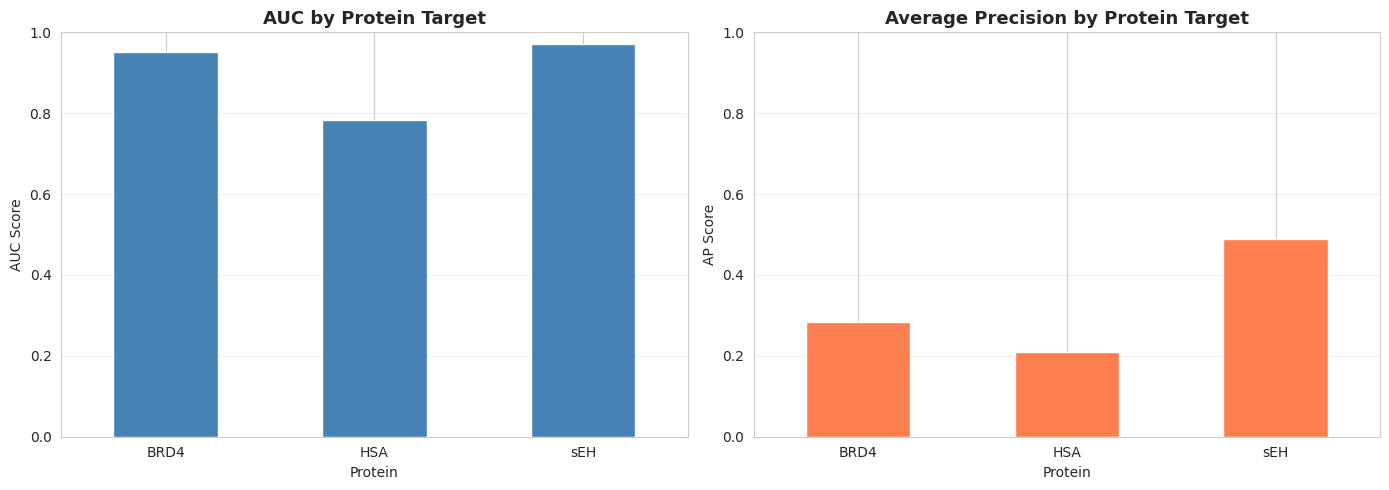

In [20]:
# Calculate metrics per protein
protein_names_list = df['protein_name'].values
proteins = df['protein_name'].unique()

protein_metrics = []

for protein in proteins:
    mask = protein_names_list == protein
    
    # Calculate for ensemble
    auc_score = roc_auc_score(y[mask], ensemble_preds[mask])
    ap_score = average_precision_score(y[mask], ensemble_preds[mask])
    
    protein_metrics.append({
        'Protein': protein,
        'AUC': auc_score,
        'Average Precision': ap_score,
        'Samples': mask.sum(),
        'Binding Rate': y[mask].mean()
    })

protein_df = pd.DataFrame(protein_metrics)

print("\n📊 PERFORMANCE BY PROTEIN TARGET (Ensemble)\n")
print(protein_df.to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

protein_df.plot(x='Protein', y='AUC', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('AUC by Protein Target', fontsize=13, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim([0, 1])
axes[0].set_xticklabels(protein_df['Protein'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

protein_df.plot(x='Protein', y='Average Precision', kind='bar', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Average Precision by Protein Target', fontsize=13, fontweight='bold')
axes[1].set_ylabel('AP Score')
axes[1].set_ylim([0, 1])
axes[1].set_xticklabels(protein_df['Protein'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

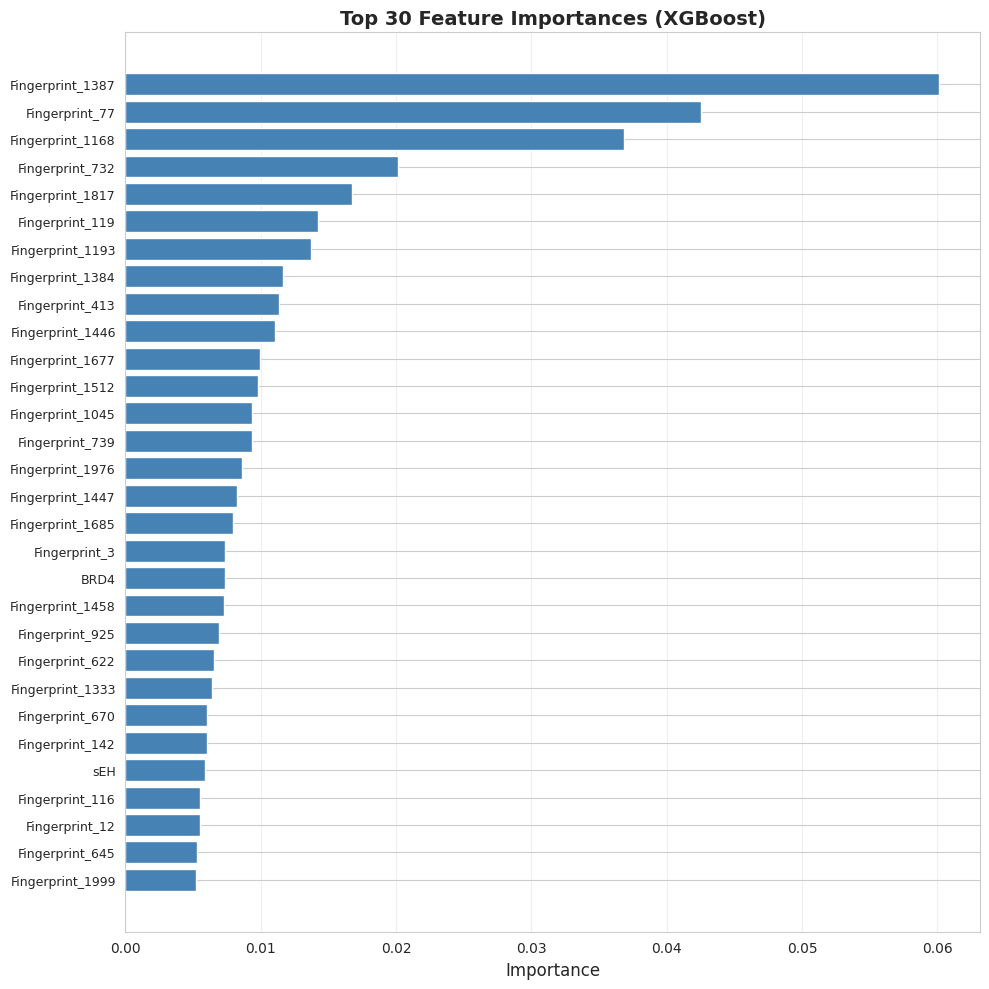


Top 10 most important features:
  1. Fingerprint_1387: 0.0601
  2. Fingerprint_77: 0.0425
  3. Fingerprint_1168: 0.0369
  4. Fingerprint_732: 0.0202
  5. Fingerprint_1817: 0.0167
  6. Fingerprint_119: 0.0142
  7. Fingerprint_1193: 0.0137
  8. Fingerprint_1384: 0.0117
  9. Fingerprint_413: 0.0113
  10. Fingerprint_1446: 0.0111


In [21]:
# Get average feature importance across folds
feature_importances = np.mean([model.feature_importances_ for model in xgb_models], axis=0)

# Get top 30 features
top_n = 30
top_indices = np.argsort(feature_importances)[-top_n:]
top_importances = feature_importances[top_indices]

# Create feature names
feature_names = [f'Fingerprint_{i}' for i in range(2048)] + list(protein_names)
top_feature_names = [feature_names[i] for i in top_indices]

# Plot
plt.figure(figsize=(10, 10))
plt.barh(range(top_n), top_importances, color='steelblue')
plt.yticks(range(top_n), top_feature_names, fontsize=9)
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important features:")
for i in range(min(10, top_n)):
    idx = top_indices[-(i+1)]
    print(f"  {i+1}. {feature_names[idx]}: {feature_importances[idx]:.4f}")

In [22]:
import joblib
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(xgb_models, 'models/xgboost_models.pkl')
joblib.dump(lgb_models, 'models/lightgbm_models.pkl')
joblib.dump(rf_models, 'models/randomforest_models.pkl')

print("✓ Models saved to 'models/' directory")
print("  - xgboost_models.pkl")
print("  - lightgbm_models.pkl")
print("  - randomforest_models.pkl")

✓ Models saved to 'models/' directory
  - xgboost_models.pkl
  - lightgbm_models.pkl
  - randomforest_models.pkl


In [23]:
# test_df = pd.read_parquet('/kaggle/input/leash-BELKA/test.parquet')
# print(f"Test data shape: {test_df.shape}")

# # Generate fingerprints for test
# print("\nGenerating fingerprints for test data...")
# test_fingerprints = []
# for smiles in test_df['molecule_smiles'].values:
#     fp = smiles_to_morgan_fingerprint(smiles)
#     test_fingerprints.append(fp)
# X_test_mol = np.array(test_fingerprints)

# # Add protein encoding
# X_test_protein = np.zeros((len(test_df), len(protein_names)))
# for i, protein in enumerate(test_df['protein_name'].values):
#     X_test_protein[i, protein_to_idx[protein]] = 1

# X_test = np.concatenate([X_test_mol, X_test_protein], axis=1)
# print(f"Test features shape: {X_test.shape}")

# # Make predictions with each model (average across folds)
# xgb_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in xgb_models], axis=0)
# lgb_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in lgb_models], axis=0)
# rf_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in rf_models], axis=0)

# # Ensemble
# test_ensemble_preds = (xgb_test_preds + lgb_test_preds + rf_test_preds) / 3

# # Create submission
# submission = pd.DataFrame({
#     'id': test_df['id'],
#     'binds': test_ensemble_preds
# })

# submission.to_csv('submission.csv', index=False)
# print("\n✓ Submission file created: submission.csv")
# print(f"\nPrediction statistics:")
# print(f"  Min:  {test_ensemble_preds.min():.4f}")
# print(f"  Max:  {test_ensemble_preds.max():.4f}")
# print(f"  Mean: {test_ensemble_preds.mean():.4f}")

In [24]:
# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("="*60)
print("MAKING PREDICTIONS ON TEST DATA (20K SAMPLE)")
print("="*60)

# Load test data from Kaggle
test_df_full = pd.read_parquet('/kaggle/input/leash-BELKA/test.parquet')
print(f"\n✓ Full test data shape: {test_df_full.shape}")

# Sample 20K molecules (stratified by protein)
SAMPLE_SIZE = 20000
print(f"\nSampling {SAMPLE_SIZE:,} test molecules...")

test_df = test_df_full.groupby('protein_name', group_keys=False).apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE // 3), random_state=42)
).reset_index(drop=True)

print(f"✓ Sampled test data shape: {test_df.shape}")
print(f"\nSample distribution by protein:")
print(test_df['protein_name'].value_counts())

# Free memory
del test_df_full
import gc
gc.collect()

# Generate fingerprints for test data
print("\nGenerating fingerprints for test molecules...")
print("This should take ~2-3 minutes...")

test_fingerprints = []
for i, smiles in enumerate(test_df['molecule_smiles'].values):
    fp = smiles_to_morgan_fingerprint(smiles)
    test_fingerprints.append(fp)
    
    # Progress tracking
    if (i + 1) % 5000 == 0:
        print(f"  Processed {i+1:,} / {len(test_df):,} molecules")

X_test_mol = np.array(test_fingerprints)
print(f"\n✓ Test molecular features: {X_test_mol.shape}")

# Add protein encoding (same as training)
X_test_protein = np.zeros((len(test_df), len(protein_names)))
for i, protein in enumerate(test_df['protein_name'].values):
    X_test_protein[i, protein_to_idx[protein]] = 1

# Combine features
X_test = np.concatenate([X_test_mol, X_test_protein], axis=1)
print(f"✓ Final test features: {X_test.shape}")

# Make predictions with each model (average across 5 folds)
print("\nMaking predictions...")
xgb_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in xgb_models], axis=0)
print("  ✓ XGBoost predictions done")

lgb_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in lgb_models], axis=0)
print("  ✓ LightGBM predictions done")

rf_test_preds = np.mean([model.predict_proba(X_test)[:, 1] for model in rf_models], axis=0)
print("  ✓ Random Forest predictions done")

# Ensemble: average all models
test_ensemble_preds = (xgb_test_preds + lgb_test_preds + rf_test_preds) / 3
print("  ✓ Ensemble predictions done")

# Create submission file (NOTE: This is a sample, not full submission!)
submission = pd.DataFrame({
    'id': test_df['id'],
    'binds': test_ensemble_preds
})

submission.to_csv('submission_sample_20k.csv', index=False)

print("\n" + "="*60)
print("✓ SAMPLE SUBMISSION CREATED: submission_sample_20k.csv")
print("="*60)
print(f"\n⚠️  NOTE: This is a 20K SAMPLE for testing!")
print(f"⚠️  For actual competition submission, predict on ALL test data")
print(f"\nPrediction statistics:")
print(f"  Number of predictions: {len(test_ensemble_preds):,}")
print(f"  Min:  {test_ensemble_preds.min():.4f}")
print(f"  Max:  {test_ensemble_preds.max():.4f}")
print(f"  Mean: {test_ensemble_preds.mean():.4f}")
print(f"  Std:  {test_ensemble_preds.std():.4f}")

print("\n📊 Distribution by protein:")
for protein in test_df['protein_name'].unique():
    mask = test_df['protein_name'] == protein
    preds = test_ensemble_preds[mask]
    print(f"  {protein}: {len(preds):,} predictions, mean={preds.mean():.4f}")

MAKING PREDICTIONS ON TEST DATA (20K SAMPLE)

✓ Full test data shape: (1674896, 6)

Sampling 20,000 test molecules...
✓ Sampled test data shape: (19998, 6)

Sample distribution by protein:
protein_name
BRD4    6666
HSA     6666
sEH     6666
Name: count, dtype: int64

Generating fingerprints for test molecules...
This should take ~2-3 minutes...
  Processed 5,000 / 19,998 molecules
  Processed 10,000 / 19,998 molecules
  Processed 15,000 / 19,998 molecules

✓ Test molecular features: (19998, 2048)
✓ Final test features: (19998, 2051)

Making predictions...
  ✓ XGBoost predictions done
  ✓ LightGBM predictions done
  ✓ Random Forest predictions done
  ✓ Ensemble predictions done

✓ SAMPLE SUBMISSION CREATED: submission_sample_20k.csv

⚠️  NOTE: This is a 20K SAMPLE for testing!
⚠️  For actual competition submission, predict on ALL test data

Prediction statistics:
  Number of predictions: 19,998
  Min:  0.0019
  Max:  0.5579
  Mean: 0.0087
  Std:  0.0178

📊 Distribution by protein:
  BRD